In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# ─── CONFIGURATION ───────────────────

In [2]:


DATA_DIR   = "data"    
MODEL_PATH = "stool_model.pth" 

IMG_SIZE   = 224
BATCH_SIZE = 16
NUM_CLASSES = 7
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# ─── VALIDATION TRANSFORMS (MUST MATCH TRAINING) ────────

In [3]:


val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])
])


# ─── DATASET CLASS ────────

In [4]:
class StoolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir  = root_dir
        self.transform = transform
        self.samples   = []    # list of (image_path, label)
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for fname in os.listdir(class_path):
                    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                        self.samples.append((os.path.join(class_path, fname), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# ─── LOAD VALIDATION DATA ──────────────────

In [5]:
# If you used a held-out split, point to only the validation split. Otherwise, this uses all images.
dataset = StoolDataset(DATA_DIR, transform=val_transforms)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ─── LOAD SAVED MODEL ───────

In [6]:
model = models.efficientnet_b0(pretrained=False)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)   # ← will error if MODEL_PATH is wrong
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


# ─── INFERENCE + METRICS ─────

In [7]:
all_preds  = []
all_labels = []
all_paths  = []

with torch.no_grad():
    for inputs, labels, paths in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_paths.extend(paths)

In [8]:
# Convert to NumPy arrays
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

class_names = sorted(os.listdir(DATA_DIR))  # ["type-1","type-2",…,"type-7"]
cm = confusion_matrix(all_labels, all_preds)

In [9]:
print("\n── Classification Report ─────────────────────────────────────────────────")
print(classification_report(all_labels, all_preds, target_names=class_names))


── Classification Report ─────────────────────────────────────────────────
              precision    recall  f1-score   support

      type-1       0.87      0.99      0.93       197
      type-2       0.93      0.93      0.93       226
      type-3       0.83      0.84      0.83       332
      type-4       0.89      0.80      0.85       316
      type-5       0.96      0.96      0.96        28
      type-6       1.00      0.96      0.98        25
      type-7       0.99      0.99      0.99       269

    accuracy                           0.90      1393
   macro avg       0.93      0.93      0.93      1393
weighted avg       0.90      0.90      0.90      1393



# ─── PLOT CONFUSION MATRIX ────────────

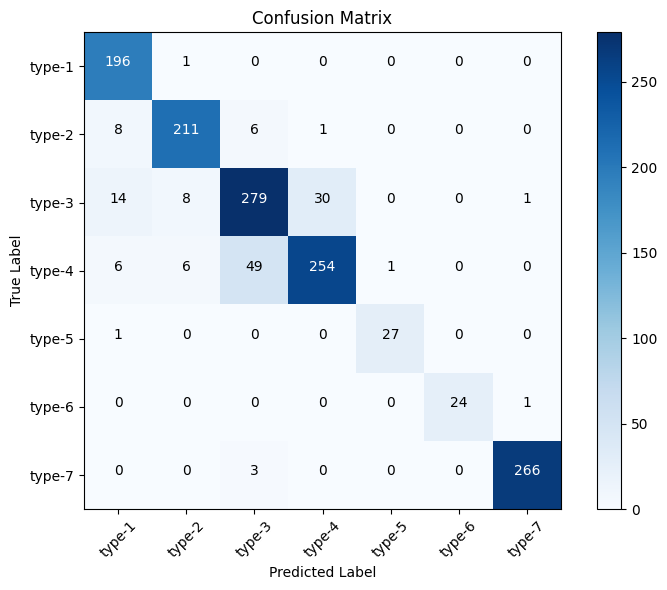

In [10]:

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], "d"),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ─── SHOW A FEW MISCLASSIFIED SAMPLES ──────────────


Total misclassified: 136


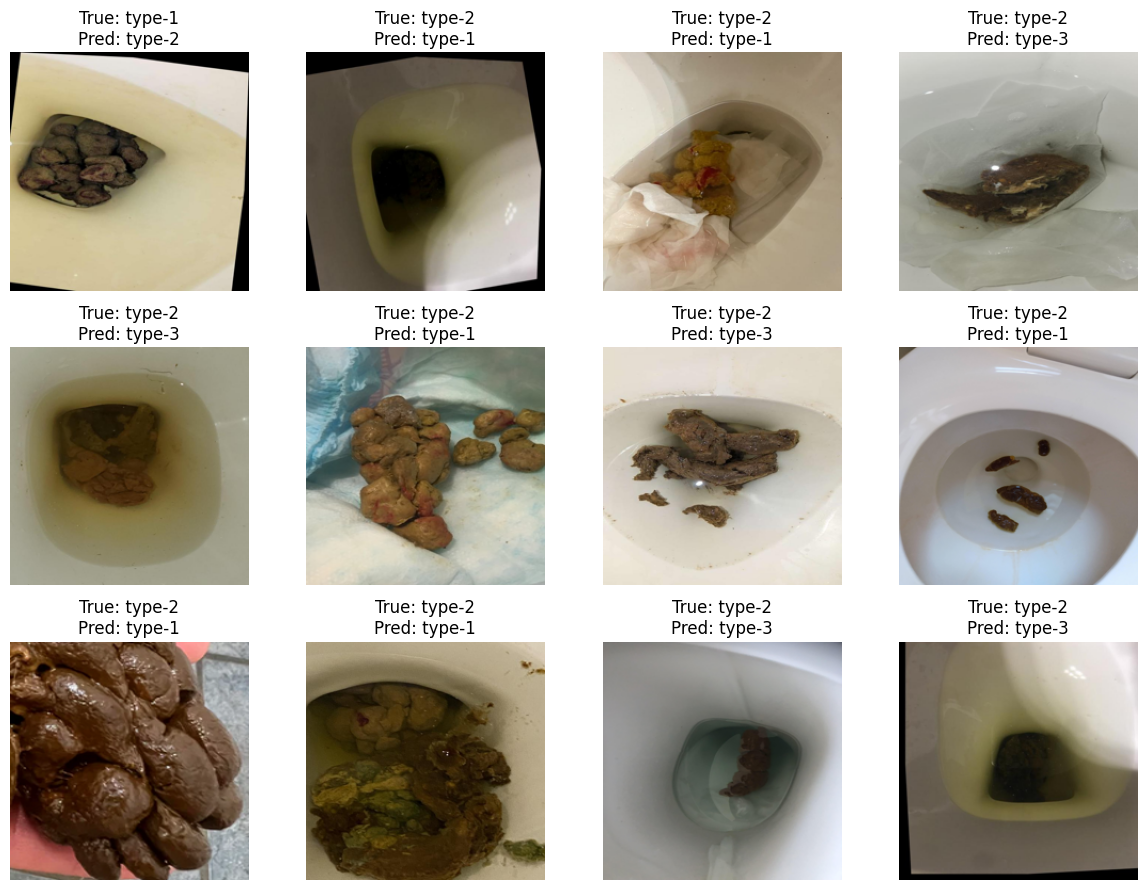

In [11]:
misclassified = [
    (path, true, pred)
    for path, true, pred in zip(all_paths, all_labels, all_preds)
    if true != pred
]
print(f"\nTotal misclassified: {len(misclassified)}")

N = 12   # how many to visualize
rows = int(np.ceil(N / 4))
plt.figure(figsize=(12, 3 * rows))

for idx, (path, true, pred) in enumerate(misclassified[:N]):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    plt.subplot(rows, 4, idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
    plt.axis("off")

plt.tight_layout()
plt.show()